In [1]:
import numpy, scipy, pandas
import matplotlib, seaborn
import matplotlib.pyplot as plt
import scipy.signal
from imp import reload

import peap
from peap import one_dim

from peap import utilities


In [2]:
reload(peap.utilities)

<module 'peap.utilities' from '/gpfs/data01/glasslab/home/dskola/workspace/ABC/peap/utilities.py'>

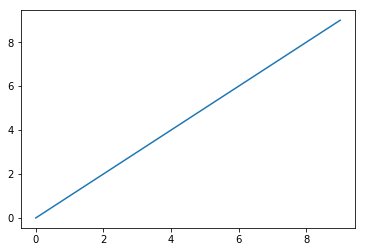

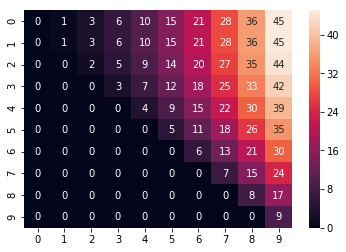

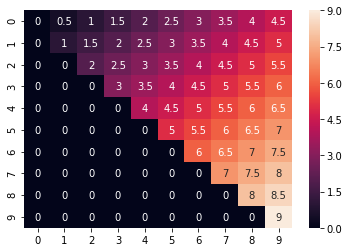

In [3]:
reload(peap.one_dim)
from peap.one_dim import *

test_vec = numpy.arange(10)

plt.plot(test_vec)
plt.show()

sums = compute_subarray_sums(test_vec)
seaborn.heatmap(sums, annot=True)
plt.show()
means = compute_subarray_means(test_vec)

seaborn.heatmap(means, annot=True)

## Distro

In [1353]:
DEFAULT_PSEUDOCOUNT = 0
RESAMPLE = False

class EmpiricalDistribution():
    _BIN_OFFSET = -1
    def __init__(self, frequencies, support):
        assert support[1] >= support[0]

        self.a, self.b = support
        self.num_bins = len(frequencies)

        self._frequencies = numpy.array(frequencies)
        self._cdf_values = numpy.cumsum(self._frequencies)
        self._sf_values = numpy.cumsum(self._frequencies[::-1])[::-1]  # Double reversal needed to avoid numerical round-off errors close to 1. Maybe we can do all this better natively in logspace?

    @staticmethod
    def fit(data, bins='auto', pseudocount=DEFAULT_PSEUDOCOUNT, support=None):
        data = numpy.array(data)
        assert len(data) > 0, 'Data must have non-zero length'
        assert sum(numpy.isnan(data)) == 0, 'Data must not contain NaN'
        assert sum(numpy.isinf(data)) == 0, 'Data must not contain inf'
        assert sum(numpy.isneginf(data)) == 0, 'Data must not contain neginf'

        if support is None:
            support = (data.min(), data.max())
#         bins=numpy.linspace(*support, num=num_bins + 1)
        counts, bins = numpy.histogram(data, bins=bins)
        counts += pseudocount
        frequencies = counts / counts.sum()
        return {'support':support, 'frequencies':frequencies}
        
    @classmethod
    def from_data(cls, data, bins='auto', pseudocount=0, support=None):
        return cls(**cls.fit(data, bins=bins, pseudocount=pseudocount, support=support))

    @property
    def frequencies(self):
        return pandas.Series(self._frequencies, index=self.bin_starts)
    
    @property
    def densities(self):
        return pandas.Series(self._frequencies / self.bin_size, index=self.bin_midpoints)

    @property
    def support_size(self):
        return self.b - self.a
    
    @property
    def support(self):
        return (self.a, self.b)
    
    @property
    def bin_size(self):
        return (self.b - self.a) / self.num_bins
    
    @property
    def bin_starts(self):
        return numpy.linspace(self.a, self.b - self.bin_size, num=self.num_bins)
    
    @property
    def bin_midpoints(self):
        return self.bin_starts + self.bin_size / 2
    
    @property
    def bin_ends(self):
        return self.bin_starts + self.bin_size

    def copy(self):
        return type(self)(frequencies=self._frequencies, support=self.support)

    def mean(self):
        """
        Returns the expectation of the random variable described by this distribution
        """
        return numpy.sum(self._frequencies * self.bin_midpoints)

    def std(self):
        """
        Returns the standard deviation of the random variable described by this distribution
        """
        m = self.mean()
        return numpy.sqrt((((self.bin_midpoints - m) ** 2) * self.frequencies).sum())
    
    def __add__(self, other):       
        try:
            new_frequencies = scipy.signal.convolve(other._frequencies, self._frequencies, mode='full', method='auto')
            new_min = self.a + other.a
            new_max = self.b + other.b  
            
            if RESAMPLE:
                new_frequencies = resample_array(arr=new_frequencies, 
                                                 new_size=self.num_bins, 
                                                 support=(new_min, new_max))
            
            return type(self)(frequencies=new_frequencies, support=(new_min, new_max))
        except AttributeError: # assume it's a scalar
            result = self.copy()
            result.a += other
            result.b += other
            return result   
        
#     def __iadd__(self, other):
#         self = self + other
#         return self
        
    def __sub__(self, other):
        other = -other
        return self + other
    
#     def __isub__(self, other):
#         self = self - other
#         return self

    @staticmethod # ToDo: convert to normal methods or find built-ins to override
    def _log2_distro(distro):
        log_support = numpy.log2(distro.support)
        xs = numpy.linspace(*log_support, num=distro.num_bins)
        log_distro = EmpiricalDistribution(frequencies=distro.pdf(2**xs) * distro.bin_size, support=log_support)
        return log_distro

    @staticmethod
    def _expon2_distro(distro):
        expon2_support = 2**numpy.array(distro.support)
        xs = numpy.linspace(*expon2_support, num=distro.num_bins)
        expon2_distro = EmpiricalDistribution(frequencies=distro.pdf(numpy.log2(xs)) * distro.bin_size, support=expon2_support)
        return expon2_distro

    def __mult__(self, other):
        log_self = self._log2_distro(self)
        try:        
            log_other = self._log2_distro(other)
            return self._expon2_distro(log_self + log_other)
        except AttributeError: # assume it's a scalar
            return log_self + numpy.log2(other)
        
    def pdf(self, x):
        """
        Returns the PDF evaluated at the points in :param:`x`
        as the density of the overlapping bins.
        """       
        freq_array = self._frequencies
        return freq_array[numpy.maximum(0, numpy.searchsorted(self.bin_starts, x) + self._BIN_OFFSET)] / self.bin_size

    def cdf(self, x):
        """
        Returns the CDF evaluated at the points in :param:`x`
        """
        return self._cdf_values[numpy.maximum(0, numpy.searchsorted(self.bin_starts, x) + self._BIN_OFFSET)]

    def sf(self, x):
        """
        Return the survival function (1 - cdf) at :param x:
        """
        return self._sf_values[numpy.maximum(0, numpy.searchsorted(self.bin_starts, x) + self._BIN_OFFSET)]
    
    def isf(self, x):
        """
        Return the inverse survival function (1 - sf) at :param x:
        """
        return 1 - self._sf_values[numpy.maximum(0, numpy.searchsorted(self.bin_starts, x) + self._BIN_OFFSET)]

    def logsf(self, x):
        # ToDo: Build in standard approximation (should never return 0 p-values)
        return numpy.log(numpy.maximum(self.sf(x), MIN_PVALUE))
    
    def __neg__(self):
        return type(self)(frequencies=self._frequencies[::-1], support=(-self.b, -self.a))

## Implement convolution stuff by overloading builtin arithmetic methods    

## Unit tests

## Develop arithmetic methods

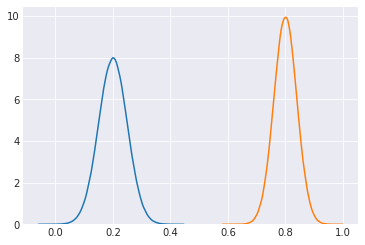

In [1354]:
n = 1000000

numpy.random.seed(2)

X = scipy.stats.norm(loc=0.2, scale=0.05).rvs(size=n)
Y = scipy.stats.norm(loc=0.8, scale=0.04).rvs(size=n)

RESAMPLE = True
X_distro = EmpiricalDistribution.from_data(X, bins=1001)
Y_distro = EmpiricalDistribution.from_data(Y, bins=1001)

seaborn.kdeplot(X)
seaborn.kdeplot(Y)
plt.show()

## Addition of two distributions

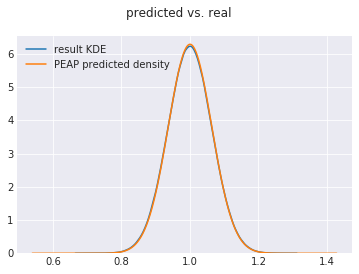

In [1355]:
result = X + Y
seaborn.kdeplot(result, label='result KDE')

predicted_result_distro = X_distro + Y_distro
plt.plot(predicted_result_distro.densities, label='PEAP predicted density')

plt.legend()
plt.suptitle('predicted vs. real')
plt.show()

## Addition of a scalar to a distribution

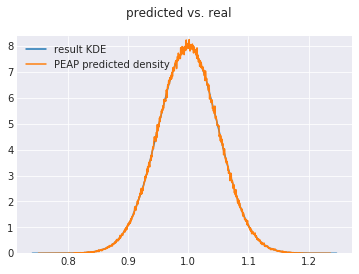

In [1356]:
result = X + 0.8
seaborn.kdeplot(result, label='result KDE')

predicted_result_distro = X_distro + 0.8
plt.plot(predicted_result_distro.densities,
         label='PEAP predicted density')

plt.legend()
plt.suptitle('predicted vs. real')
plt.show()

## Subtraction of two distributions

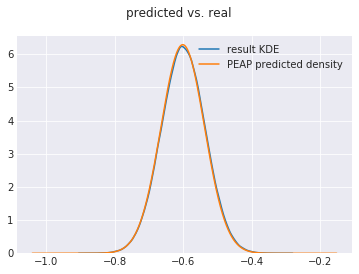

In [1357]:
result = X - Y
seaborn.kdeplot(result, label='result KDE')

predicted_result_distro = X_distro - Y_distro
plt.plot(predicted_result_distro.densities,
         label='PEAP predicted density')

plt.legend()
plt.suptitle('predicted vs. real')
plt.show()

## Subtraction of a scalar from a distribution

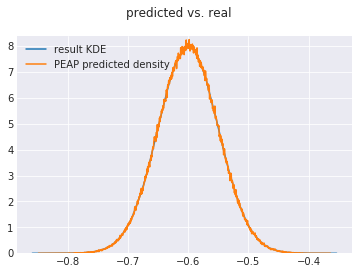

In [1358]:
result = X - 0.8
seaborn.kdeplot(result, label='result KDE')

predicted_result_distro = X_distro - 0.8
plt.plot(predicted_result_distro.densities,
         label='PEAP predicted density')

plt.legend()
plt.suptitle('predicted vs. real')
plt.show()

# Multiplication as implemented by self-summing

Mean Z: 10.0002738842719, Mean X x 50: 10.0


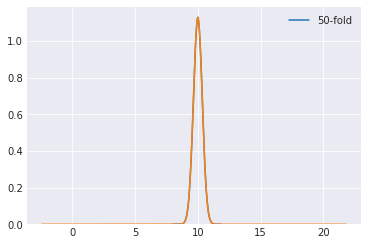

In [1359]:
RESAMPLE=False
num_mults = 50

Z = numpy.copy(X)
for i in range(num_mults-1):
    Z += scipy.stats.norm(0.2, scale=0.05).rvs(n)

seaborn.kdeplot(Z, label='50-fold')
print('Mean Z: {}, Mean X x 50: {}'.format(numpy.mean(Z), 0.2*50))

predicted_Z_distro = numpy.sum([X_distro]*50)
plt.plot(predicted_Z_distro.densities)

Mean Z: 10.00017694680522, Mean X x 50: 10.0


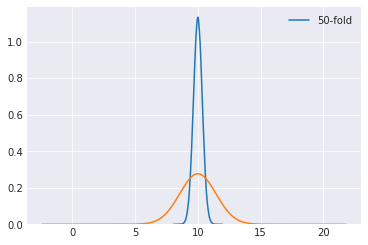

In [1360]:
RESAMPLE=True
num_mults = 50

Z = numpy.copy(X)
for i in range(num_mults-1):
    Z += scipy.stats.norm(0.2, scale=0.05).rvs(n)

seaborn.kdeplot(Z, label='50-fold')
print('Mean Z: {}, Mean X x 50: {}'.format(numpy.mean(Z), 0.2*50))

predicted_Z_distro = numpy.sum([X_distro]*50)
plt.plot(predicted_Z_distro.densities)

## Try logs again

Mean Z: 9.999928830200167, Mean X x 50: 10.0


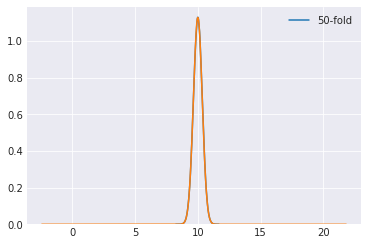

In [1361]:
RESAMPLE=False
num_mults = 50

Z = numpy.copy(X)
for i in range(num_mults-1):
    Z += scipy.stats.norm(0.2, scale=0.05).rvs(n)

seaborn.kdeplot(Z, label='50-fold')
print('Mean Z: {}, Mean X x 50: {}'.format(numpy.mean(Z), 0.2*50))

predicted_Z_distro = numpy.sum([X_distro]*50)
plt.plot(predicted_Z_distro.densities)

In [1362]:
M = scipy.stats.norm().rvs(n)
M_distro = EmpiricalDistribution.from_data(M)

In [ ]:
print(M_distro.support)
plt.plot(M_distro.densities)

In [ ]:
def split_distro(distro, split_point=0):
    if split_point > distro.a:
        left_bin_membership = numpy.less(distro.bin_starts, split_point)
        left_bin_starts = distro.bin_starts[left_bin_membership]

        left_distro = EmpiricalDistribution(frequencies=distro._frequencies[left_bins], support=(distro.a, ))
        
        right_bin_membership = numpy.logical_not(left_bin_membership)
        right_bin_starts = distro.bin_starts[right_bin_membership]

In [ ]:
def log2_distro(distro):
    log_support = numpy.log2(distro.support)
    xs = numpy.linspace(*log_support, num=distro.num_bins)
    log_distro = EmpiricalDistribution(frequencies=distro.pdf(2**xs) * distro.bin_size, support=log_support)
    return log_distro

def expon2_distro(distro):
    expon2_support = 2**numpy.array(distro.support)
    print(expon2_support)
    xs = numpy.linspace(*expon2_support, num=distro.num_bins)
    expon2_distro = EmpiricalDistribution(frequencies=distro.pdf(numpy.log2(xs)) * distro.bin_size, support=expon2_support)
    return expon2_distro

def test_mult(self, other):
    log_self = log2_distro(self)
    try:        
        log_other = log2_distro(other)
        return expon2_distro(log_self + log_other)
    except AttributeError: # assume it's a scalar
        return log_self + numpy.log2(other)

In [ ]:
numpy.log2(X_distro.support)

In [652]:
import cmath

In [662]:
p = cmath.exp(cmath.log(numpy.e))
p.real

2.718281828459045

In [664]:
cmath.log(-numpy.e)

(1+3.141592653589793j)

In [651]:
a, b = (-2, 4)
print(b - a)
print(numpy.log2(-a), numpy.log2(b))
print(2**1, 2**2)

6
1.0 2.0
2 4


In [ ]:
def sign_preserving

In [641]:
X_distro.__mult__(50)

/home/dskola/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:111: RuntimeWarning: invalid value encountered in log2


AssertionError: 

In [610]:
X_distro.__mult__ = test_mult

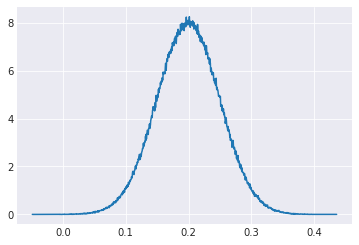

In [611]:
plt.plot(X_distro.densities)

In [624]:
plt.plot((X_distro * 50).densities)

TypeError: unsupported operand type(s) for *: 'EmpiricalDistribution' and 'int'

In [596]:
RESAMPLE = False

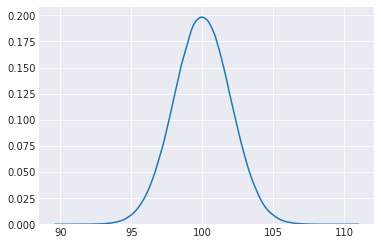

In [597]:
V = scipy.stats.norm(loc=100, scale=2).rvs(n)
seaborn.kdeplot(V)

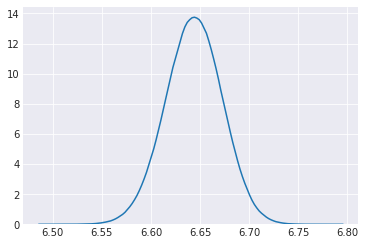

In [598]:
V_log = numpy.log2(V)
seaborn.kdeplot(V_log)

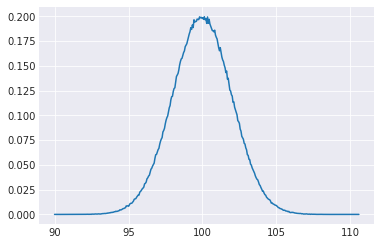

In [643]:
V_distro = EmpiricalDistribution.from_data(V)
plt.plot(V_distro.densities)

In [605]:
2**numpy.array((6.491548104230231, 6.789843056137696))

array([ 89.98097561, 110.64872801])

In [644]:
print(V_distro.support)
V_distro_log = log2_distro(V_distro)
print(V_distro_log.support)
V_distro_log += numpy.log2(50)
print(V_distro_log.support)
multiplied_distro = expon2_distro(V_distro_log)
print(multiplied_distro.support)

(89.9809756137465, 110.6487280091361)
(6.491548104230231, 6.789843056137696)
(12.135404294004957, 12.43369924591242)
[4499.04878069 5532.43640046]
(4499.048780687325, 5532.436400456804)


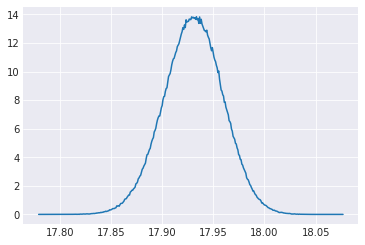

In [603]:
V_distro_log += numpy.log2(50)
plt.plot(V_distro_log.densities)

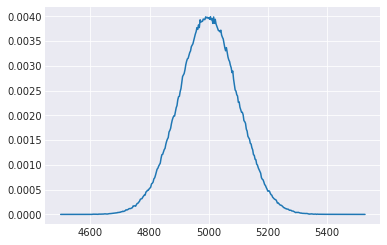

In [607]:
plt.plot(multiplied_distro.densities)

## Try shifting

Mean Z: 9.999428044932143, Mean X x 50: 10.0


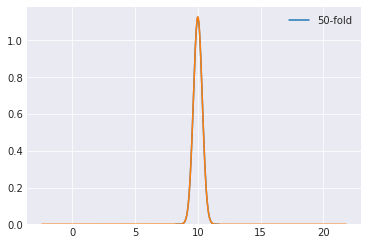

In [1363]:
RESAMPLE=False
num_mults = 50

Z = numpy.copy(X)
for i in range(num_mults-1):
    Z += scipy.stats.norm(0.2, scale=0.05).rvs(n)

seaborn.kdeplot(Z, label='50-fold')
print('Mean Z: {}, Mean X x 50: {}'.format(numpy.mean(Z), 0.2*50))

predicted_Z_distro = numpy.sum([X_distro]*50)
plt.plot(predicted_Z_distro.densities)

In [1102]:
X_distro.support

(-0.04889322227768597, 0.436505690646554)

In [771]:
# def log2_distro(distro):
#     log_support = numpy.log2(distro.support)
#     xs = numpy.linspace(*log_support, num=distro.num_bins)
#     log_distro = EmpiricalDistribution(frequencies=distro.pdf(2**xs) * distro.bin_size, support=log_support)
#     return log_distro

# def expon2_distro(distro):
#     expon2_support = 2**numpy.array(distro.support)
#     print(expon2_support)
#     xs = numpy.linspace(*expon2_support, num=distro.num_bins)
#     expon2_distro = EmpiricalDistribution(frequencies=distro.pdf(numpy.log2(xs)) * distro.bin_size, support=expon2_support)
#     return expon2_distro

# def test_mult(self, other):
#     # If support includes negative values, shift it to start at +1 to avoid invalid logarithms
#     if other.a <= 0:
#         self_offset = -self.a + 1
#         shifted_other = self + self_offset
#     else:
#         self_offset = 0
#         shifted_self = self
#     log_self = log2_distro(shifted_self)
    
#     try:        
#         if other.a <= 0:
#             other_offset = -other.a + 1
#             shifted_other = other + other_offset
#         else:
#             other_offset = 0
#             shifted_other = other
#         log_other = log2_distro(shifted_other)

#         result = expon2_distro(log_other + log_other)
    
#         print(self_offset, other_offset)
        
#         return result

#     except AttributeError: # assume it's a scalar
#         if other <= 0:
#             other_offset = -other + 1
#             other += other_offset
#         else:
#             other_offset = 0
#         result = expon2_distro(log_self + numpy.log2(other))
#         print(self_offset, other_offset)
#         return result  - self_offset * other

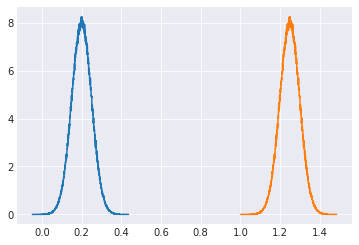

In [1364]:
shift_offset = - X_distro.a + 1
shifted_distro = X_distro + shift_offset

plt.plot(X_distro.densities)
plt.plot(shifted_distro.densities)

In [773]:
numpy.seterr(all='warn')
import warnings

warnings.filterwarnings('error')

In [759]:
mult_distro = test_mult(shifted_distro, 50)
unshifted_distro = mult_distro - shift_offset * 50

[50.         74.26994565]


In [760]:
shifted_distro.support

(0.9999999999999999, 1.4853989129242398)

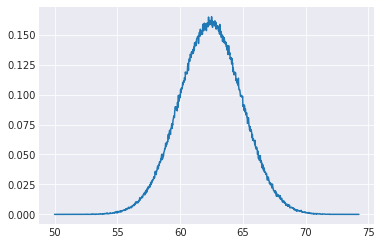

In [761]:
plt.plot(mult_distro.densities)


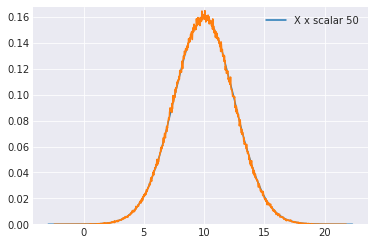

In [764]:
seaborn.kdeplot(X*50, label='X x scalar 50')

plt.plot(unshifted_distro.densities)


In [892]:
log_X = numpy.log2(X)

In [1365]:
def log2_distro(distro):
    num_bins_log = int(distro.num_bins * 4)
    log_support = numpy.log2(distro.support)
    bin_size_log = (log_support[1] - log_support[0]) / num_bins_log
    log_midpoints = numpy.linspace(log_support[0], log_support[1] - bin_size_log, num=num_bins_log) + bin_size_log / 2
    sampling_points = 2**log_midpoints - bin_size_log
    log_distro = EmpiricalDistribution(frequencies=distro.pdf(sampling_points) * bin_size_log,
                                       support=log_support)
    log_distro._frequencies /= log_distro._frequencies.sum()
    return log_distro

# def expon2_distro(distro):
#     num_bins_expon2 = int(distro.num_bins * 3)
#     expon2_support = 2**numpy.array(distro.support)
#     bin_size_expon2 = (expon2_support[1] - expon2_support[0]) / num_bins_expon2
#     expon2_midpoints = numpy.linspace(expon2_support[0], expon2_support[1] - bin_size_expon2) + bin_size_expon2 / 2
#     sampling_points = numpy.log2(expon2_midpoints) + bin_size_expon2
#     expon2_distro = EmpiricalDistribution(frequencies=distro.pdf(sampling_points) * bin_size_expon2,
#                                           support=expon2_support)
#     expon2_distro._frequencies /= expon2_distro._frequencies.sum()
#     return expon2_distro

def expon2_distro(distro):
    num_bins_expon2 = int(distro.num_bins * 4)
    expon2_support = 2**numpy.array(distro.support)
    bin_size_expon2 = (expon2_support[1] - expon2_support[0]) / num_bins_expon2
#     expon2_starts = numpy.linspace(expon2_support[0], expon2_support[1] - bin_size_expon2)
    expon2_midpoints = numpy.linspace(expon2_support[0], expon2_support[1] - bin_size_expon2) + bin_size_expon2 / 2


#     expon2_midpoints = numpy.linspace(expon2_support[0], expon2_support[1] - bin_size_expon2) + bin_size_expon2 / 2
    sampling_points = numpy.log2(expon2_midpoints)
    expon2_distro = EmpiricalDistribution(frequencies=distro.pdf(sampling_points) * bin_size_expon2,
                                          support=expon2_support - bin_size_expon2 / 2)
    expon2_distro._frequencies /= expon2_distro._frequencies.sum()
    return expon2_distro



In [1366]:
x = 3
y = 5

In [1367]:
shift_x = 2
shift_y = 4
result = (x+shift_x) * (y+shift_y)
print(result)
result -= y * shift_x + x * shift_y + shift_x * shift_y
print(result)

45
15


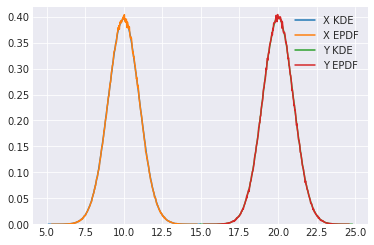

In [1368]:
X = scipy.stats.norm(loc=10, scale=1).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)
seaborn.kdeplot(X, label='X KDE')
plt.plot(X_distro.densities, label='X EPDF')

Y = scipy.stats.norm(loc=20, scale=1).rvs(n)
Y_distro = EmpiricalDistribution.from_data(Y)
seaborn.kdeplot(Y, label='Y KDE')
plt.plot(Y_distro.densities, label='Y EPDF')
plt.legend(loc=0)

In [1369]:
log_X = numpy.log2(X)
log_Y = numpy.log2(Y)

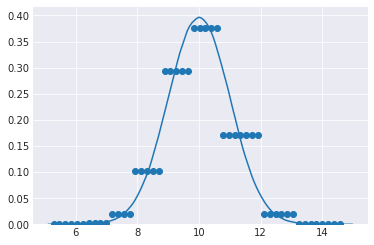

In [1370]:
expon2_X = 2**numpy.log2(X)
X_distro = EmpiricalDistribution.from_data(numpy.log2(X), bins=10)
X_distro_expon2 = expon2_distro(X_distro)

seaborn.kdeplot(expon2_X)

plt.scatter(X_distro_expon2.densities.index, X_distro_expon2.densities)

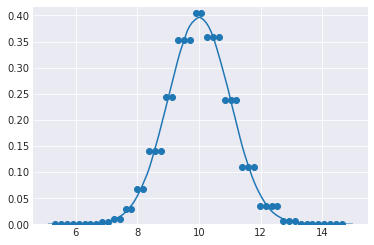

In [1371]:
expon2_X = 2**numpy.log2(X)
X_distro = EmpiricalDistribution.from_data(numpy.log2(X), bins=20)
X_distro_expon2 = expon2_distro(X_distro)

seaborn.kdeplot(expon2_X)

plt.scatter(X_distro_expon2.densities.index, X_distro_expon2.densities)

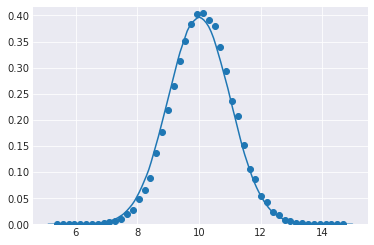

In [1372]:
expon2_X = 2**numpy.log2(X)
X_distro = EmpiricalDistribution.from_data(numpy.log2(X), bins=100)
X_distro_expon2 = expon2_distro(X_distro)

seaborn.kdeplot(expon2_X)

# plt.plot(X_distro_expon2.densities)
plt.scatter(X_distro_expon2.densities.index, X_distro_expon2.densities)

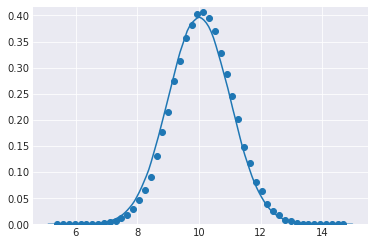

In [1373]:
expon2_X = 2**numpy.log2(X)
X_distro = EmpiricalDistribution.from_data(numpy.log2(X), bins=1000)
X_distro_expon2 = expon2_distro(X_distro)

seaborn.kdeplot(expon2_X)

# plt.plot(X_distro_expon2.densities)
plt.scatter(X_distro_expon2.densities.index, X_distro_expon2.densities)

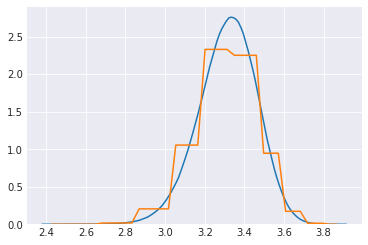

In [1374]:
X_distro = EmpiricalDistribution.from_data(X, bins=10)
X_distro_log = log2_distro(X_distro)

seaborn.kdeplot(log_X)
plt.plot(X_distro_log.densities)

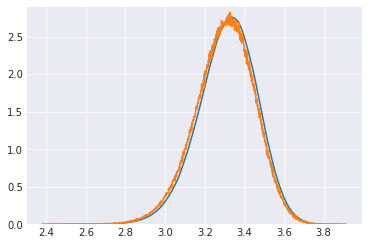

In [1375]:
X_distro = EmpiricalDistribution.from_data(X, bins=1000)
X_distro_log = log2_distro(X_distro)

seaborn.kdeplot(log_X)
plt.plot(X_distro_log.densities)

## Test shift method with neg-spanning distribution and positive scalar

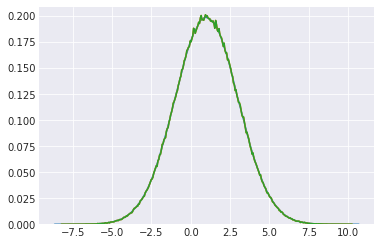

In [1376]:
numpy.random.seed(1)
X = scipy.stats.norm(loc=1, scale=2).rvs(n)
X_distro = EmpiricalDistribution.from_data(X, bins='auto')
seaborn.kdeplot(X)
plt.plot(X_distro.densities)
plt.plot(X_distro.bin_midpoints, X_distro._frequencies / X_distro.bin_size)

9.262217863883743


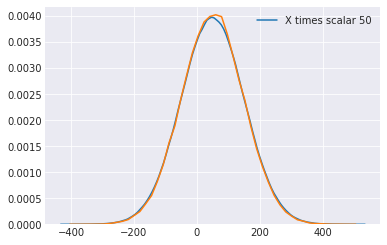

In [1377]:
seaborn.kdeplot(X*50, label='X times scalar 50')
X_distro_times_50 = test_mult(X_distro, 50)

plt.plot(X_distro_times_50.densities)

## Test shift method with neg-spanning distribution and negative scalar

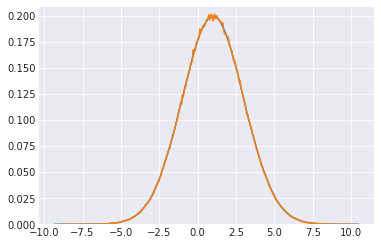

In [1378]:
X = scipy.stats.norm(loc=1, scale=2).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)
seaborn.kdeplot(X)
plt.plot(X_distro.densities)

9.926897037472314


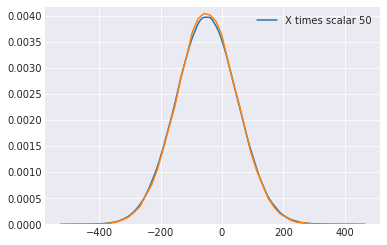

In [1379]:
seaborn.kdeplot(X*-50, label='X times scalar 50')
X_distro_times_neg_50 = test_mult(X_distro, -50)

plt.plot(X_distro_times_neg_50.densities)

## OK, now for the tricky part. Multiplying two distributions
## First, two positive distributions

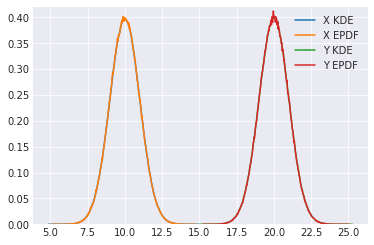

In [1380]:
X = scipy.stats.norm(loc=10, scale=1).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)
seaborn.kdeplot(X, label='X KDE')
plt.plot(X_distro.densities, label='X EPDF')

Y = scipy.stats.norm(loc=20, scale=1).rvs(n)
Y_distro = EmpiricalDistribution.from_data(Y)
seaborn.kdeplot(Y, label='Y KDE')
plt.plot(Y_distro.densities, label='Y EPDF')
plt.legend(loc=0)

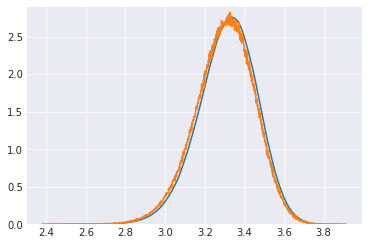

In [1381]:
seaborn.kdeplot(log_X)
plt.plot(X_distro_log.densities)

In [1404]:
# def test_mult(self, other):
#     # If support includes negative values, shift it to start at +1 to avoid invalid logarithms
#     if self.a <= 0:
#         self_offset = -self.a + 1
#         shifted_self = self + self_offset
#     else:
#         self_offset = 0
#         shifted_self = self
#     log_self = log2_distro(shifted_self)
    
#     try:        
#         if other.a <= 0:
#             other_offset = -other.a + 1
#             shifted_other = other + other_offset
#         else:
#             other_offset = 0
#             shifted_other = other
            
#         log_other = log2_distro(shifted_other)

#         result = expon2_distro(log_other + log_other)
        
#         if self_offset > 0 and other_offset > 0:
#             result = result - self.mean() * other_offset - other.mean() * self_offset - self_offset * other_offset
#             print('Need to undo double shift')
# #             result = result - test_mult(self, other_offset) - test_mult(other, self_offset) - self_offset * other_offset

#         print(self_offset, other_offset)
        
#         return result

#     except AttributeError: # assume it's a scalar
#         other_is_pos = other > 0
        
#         if not other_is_pos:
#             other = -other
        
#         result = expon2_distro(log_self + numpy.log2(other))

#         print(self_offset)
#         result -= self_offset * other
#         if not other_is_pos:
#             result = -result
#         return result

In [1383]:
log_X_distro = log2_distro(X_distro)
log_Y_distro = log2_distro(Y_distro)

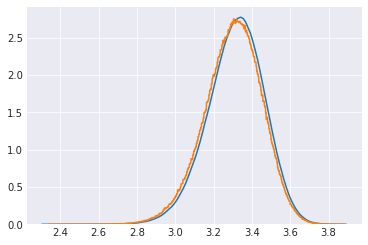

In [1314]:
seaborn.kdeplot(log_X)
plt.plot(log_X_distro.densities)

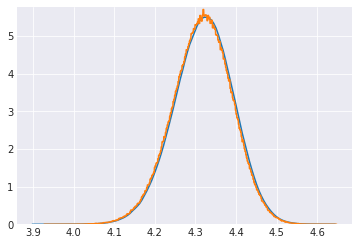

In [1315]:
seaborn.kdeplot(log_Y)
plt.plot(log_Y_distro.densities)

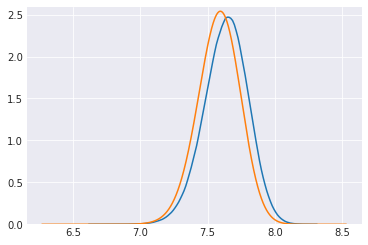

In [1316]:
seaborn.kdeplot(log_X + log_Y)
log_sum_distro = log_X_distro + log_Y_distro
plt.plot(log_sum_distro.densities)

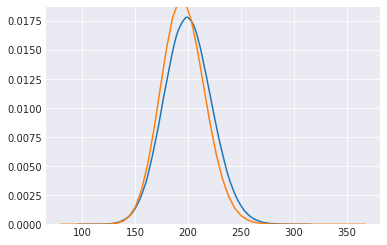

In [1317]:
seaborn.kdeplot(2**(log_X + log_Y))
expon_sum = expon2_distro(log_sum_distro)
plt.plot(expon_sum.densities)

In [1318]:
X_distro.support, Y_distro.support

((4.664986707721988, 15.181813576916598),
 (15.051000619880867, 25.026711123086603))

0 0


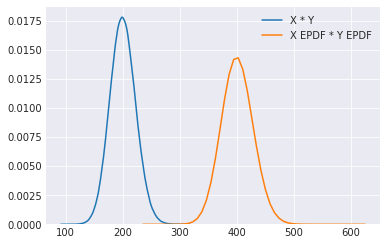

In [1384]:
seaborn.kdeplot(X*Y, label='X * Y')
X_distro_times_Y_distro = test_mult(X_distro, Y_distro)

plt.plot(X_distro_times_Y_distro.densities, label='X EPDF * Y EPDF')
plt.legend(loc=0)

## Two negative-spanning distributions

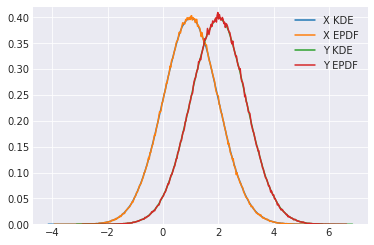

In [1399]:
X = scipy.stats.norm(loc=1, scale=1).rvs(n)
X_distro = EmpiricalDistribution.from_data(X)
seaborn.kdeplot(X, label='X KDE')
plt.plot(X_distro.densities, label='X EPDF')

Y = scipy.stats.norm(loc=2, scale=1).rvs(n)
Y_distro = EmpiricalDistribution.from_data(Y)
seaborn.kdeplot(Y, label='Y KDE')
plt.plot(Y_distro.densities, label='Y EPDF')
plt.legend(loc=0)

In [1400]:
numpy.array(X_distro_times_Y_distro.support) / 20

array([-0.18361968,  0.30809621])

Need to undo double shift
4.9522676293675065 3.925477899904812


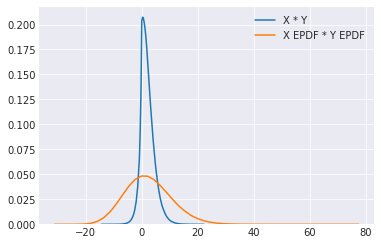

In [1407]:
seaborn.kdeplot(X*Y, label='X * Y')
X_distro_times_Y_distro = test_mult(X_distro, Y_distro)

X_distro_times_Y_distro.a, X_distro_times_Y_distro.b = numpy.array(X_distro_times_Y_distro.support)

plt.plot(X_distro_times_Y_distro.densities, label='X EPDF * Y EPDF')
plt.legend(loc=0)

In [1402]:
x_offset = 4.925477899904812
y_offset = 4.160320245274997

In [1389]:
X_distro.mean() * y_offset

4.153879134454746

In [1390]:
Y_distro.mean() * x_offset

9.853080762996617

In [1391]:
x_offset * y_offset

20.491565424628565

In [1392]:
X_distro.mean() * y_offset + Y_distro.mean() * x_offset + x_offset * y_offset

34.49852532207993

In [1393]:
X_distro_times_Y_distro.mean() - 2

-1.5911483962544037

# Piecewise convolution.

## Also, doing variable-sized bins is probably the way to address the issues with logs and exponentiation.

### But . . . for now, let's cut this party short 

In [ ]:
def test_mult(self, other):
    # If support includes negative values, shift it to start at +1 to avoid invalid logarithms
    if self.a <= 0:
        self_offset = -self.a + 1
        shifted_self = self + self_offset
    else:
        self_offset = 0
        shifted_self = self
    log_self = log2_distro(shifted_self)
    
    try:        
        if other.a <= 0:
            other_offset = -other.a + 1
            shifted_other = other + other_offset
        else:
            other_offset = 0
            shifted_other = other
            
        log_other = log2_distro(shifted_other)

        result = expon2_distro(log_other + log_other)
        
        if self_offset > 0 and other_offset > 0:
            result = result - self.mean() * other_offset - other.mean() * self_offset - self_offset * other_offset
            print('Need to undo double shift')
#             result = result - test_mult(self, other_offset) - test_mult(other, self_offset) - self_offset * other_offset

        print(self_offset, other_offset)
        
        return result

    except AttributeError: # assume it's a scalar
        other_is_pos = other > 0
        
        if not other_is_pos:
            other = -other
        
        result = expon2_distro(log_self + numpy.log2(other))

        print(self_offset)
        result -= self_offset * other
        if not other_is_pos:
            result = -result
        return result

## Complex number approach (allows negative logarithms but complicates a lot of the internal code)

In [763]:
numpy.linspace((1 + 3j), (2 + 4j))

array([1.        +3.j        , 1.02040816+3.02040816j,
       1.04081633+3.04081633j, 1.06122449+3.06122449j,
       1.08163265+3.08163265j, 1.10204082+3.10204082j,
       1.12244898+3.12244898j, 1.14285714+3.14285714j,
       1.16326531+3.16326531j, 1.18367347+3.18367347j,
       1.20408163+3.20408163j, 1.2244898 +3.2244898j ,
       1.24489796+3.24489796j, 1.26530612+3.26530612j,
       1.28571429+3.28571429j, 1.30612245+3.30612245j,
       1.32653061+3.32653061j, 1.34693878+3.34693878j,
       1.36734694+3.36734694j, 1.3877551 +3.3877551j ,
       1.40816327+3.40816327j, 1.42857143+3.42857143j,
       1.44897959+3.44897959j, 1.46938776+3.46938776j,
       1.48979592+3.48979592j, 1.51020408+3.51020408j,
       1.53061224+3.53061224j, 1.55102041+3.55102041j,
       1.57142857+3.57142857j, 1.59183673+3.59183673j,
       1.6122449 +3.6122449j , 1.63265306+3.63265306j,
       1.65306122+3.65306122j, 1.67346939+3.67346939j,
       1.69387755+3.69387755j, 1.71428571+3.71428571j,
       1.7

In [724]:
xs = numpy.linspace(-1, 1)


TypeError: only length-1 arrays can be converted to Python scalars

In [726]:
freqs = scipy.stats.norm().rvs(n)
support = cmath.log(-1), cmath.log(1)
complex_distro = EmpiricalDistribution(freqs, support)

TypeError: '>=' not supported between instances of 'complex' and 'complex'

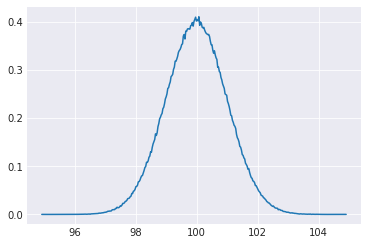

In [727]:
U_distro = EmpiricalDistribution.from_data(scipy.stats.norm(loc=100, scale=1).rvs(n))
plt.plot(U_distro.densities)

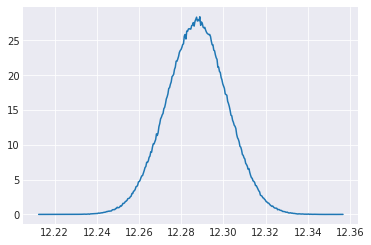

In [728]:
plt.plot(test_mult(U_distro, 50).densities)